In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/edb-313/Football_players_trasfer_value/main/joined_final.csv')

## EDA

In [2]:
df.head()

,player_name,age,position,club_involved_name,transfer_period,fee_cleaned,year,cum_MP,cum_Min,cum_Gls,cum_Ast,cum_PK,cum_CrdY,cum_CrdR,cum_GlsxMin,cum_AstxMin,cum_G+AxMin,days_remaining
0,Ángel Di María,22.0,Right Winger,Real Madrid,Summer,33000000.0,2010,25.803939,2141.138045,4.651992,9.944212,0.0,8.270653,0.891186,0.192942,0.401788,0.594730,1825.0
1,Ramires,23.0,Central Midfield,Chelsea,Summer,22000000.0,2010,26.000000,1945.000000,4.000000,3.000000,0.0,2.000000,0.000000,0.190000,0.140000,0.320000,1782.0
2,Fábio Coentrão,23.0,Left-Back,Real Madrid,Summer,30000000.0,2011,23.022324,2018.823073,1.780261,3.257877,0.0,7.210056,1.780261,0.080112,0.145091,0.225203,1456.0
3,Roberto,25.0,Goalkeeper,Real Zaragoza,Summer,8600000.0,2011,25.000000,2227.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,1761.0
4,Axel Witsel,23.0,Defensive Midfield,Zenit S-Pb,Summer,40000000.0,2012,29.000000,2281.000000,1.000000,3.000000,1.0,5.000000,0.000000,0.040000,0.120000,0.160000,760.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_name         46 non-null     object 
 1   age                 46 non-null     float64
 2   position            46 non-null     object 
 3   club_involved_name  46 non-null     object 
 4   transfer_period     46 non-null     object 
 5   fee_cleaned         46 non-null     float64
 6   year                46 non-null     int64  
 7   cum_MP              46 non-null     float64
 8   cum_Min             46 non-null     float64
 9   cum_Gls             46 non-null     float64
 10  cum_Ast             46 non-null     float64
 11  cum_PK              46 non-null     float64
 12  cum_CrdY            46 non-null     float64
 13  cum_CrdR            46 non-null     float64
 14  cum_GlsxMin         46 non-null     float64
 15  cum_AstxMin         46 non-null     float64
 16  cum_G+AxMi

* No null values
* All columns are in the correct format

In [4]:
#drop player_name column as ID column
df.drop('player_name',axis=1,inplace=True)

In [5]:
# define position groups
position_groups = {
    'Defense': ['Left-Back', 'Centre-Back','Right-Back'],
    'Midfield': ['Central Midfield','Defensive Midfield','Left Midfield','Attacking Midfield'],
    'Attack': ['Second Striker','Centre-Forward','Right Winger','Left Winger'],
}

# create a new column with job groups
df['position_group'] = 'Goalkeeper'
for position_group, position_titles in position_groups.items():
    df.loc[df['position'].isin(position_titles), 'position_group'] = position_group

In [6]:
df.drop('position',axis = 1,inplace = True)

In [7]:
# define position groups
league = {
    'Premier League': ['Chelsea','Man City','Man Utd','Nottm Forest','Arsenal','Liverpool','Fulham'],
    'La Liga': ['Real Madrid','Real Zaragoza','Celta de Vigo','Atlético Madrid','Barcelona','Valencia','Espanyol','Granada CF'],
    'Ligue 1': ['Paris SG','Marseille'],
    'Bundensliga':['Bayern Munich','VfL Wolfsburg']
}

# create a new column with job groups
df['league'] = 'Other'
for club_group, club_name in league.items():
    df.loc[df['club_involved_name'].isin(club_name), 'league'] = club_group

In [8]:
df.drop('club_involved_name',axis = 1,inplace = True)

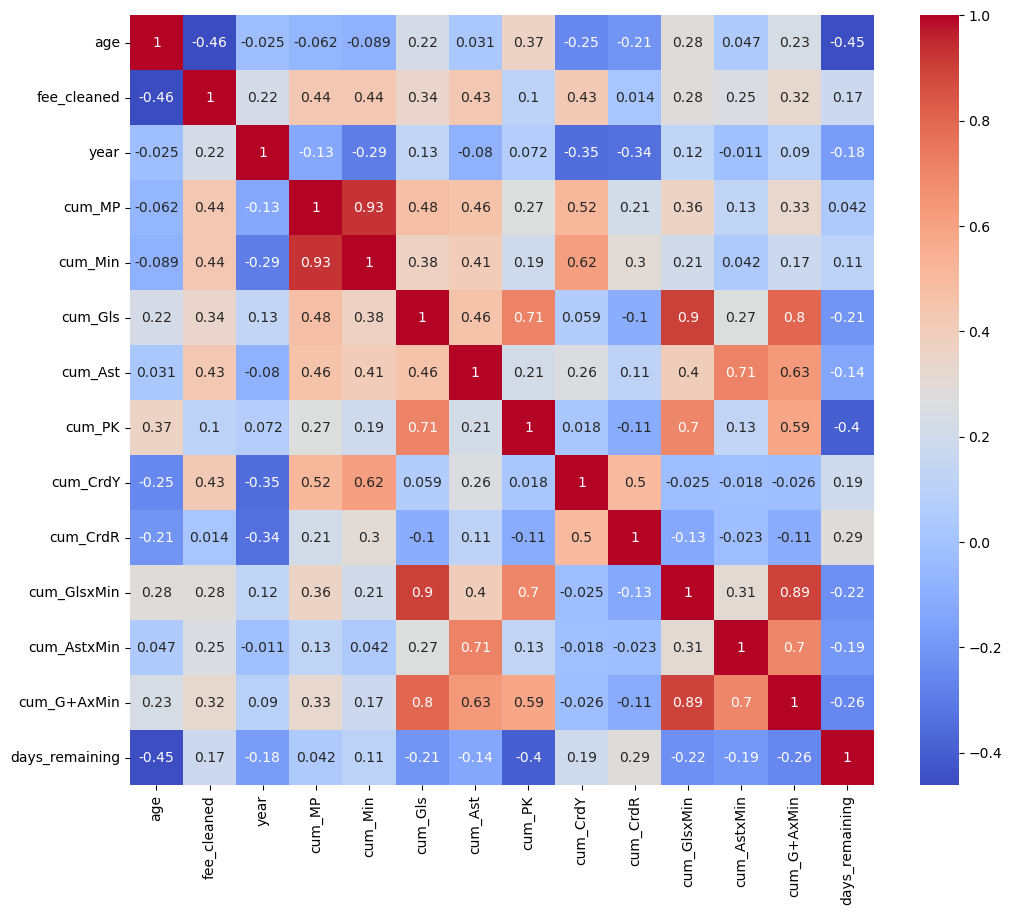

In [9]:
#Heat Map
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', ax=ax)

# Show the Heat Map
plt.show()

In [10]:
#remove variables with high correlations
df.drop(['cum_MP','cum_GlsxMin','cum_AstxMin', 'cum_G+AxMin'],axis=1,inplace = True)

In [11]:
df.columns

Index(['age', 'transfer_period', 'fee_cleaned', 'year', 'cum_Min', 'cum_Gls',
       'cum_Ast', 'cum_PK', 'cum_CrdY', 'cum_CrdR', 'days_remaining',
       'position_group', 'league'],
      dtype='object')

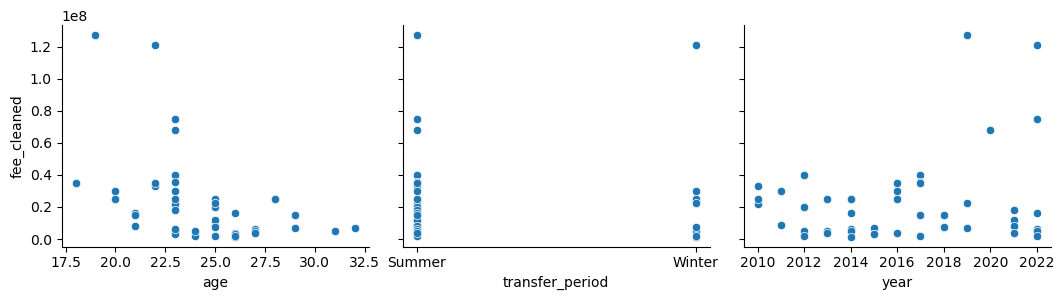

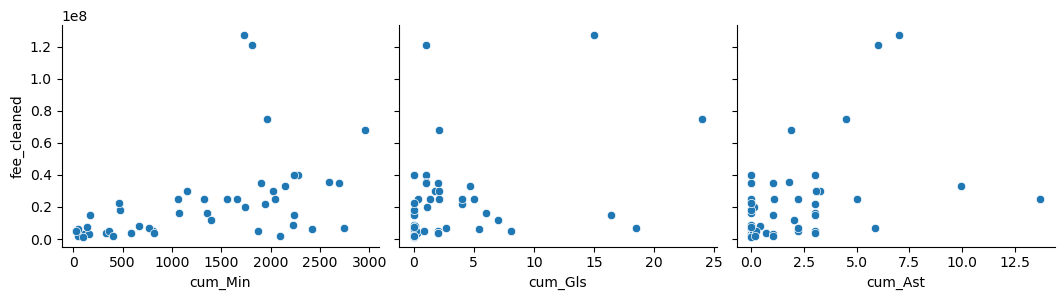

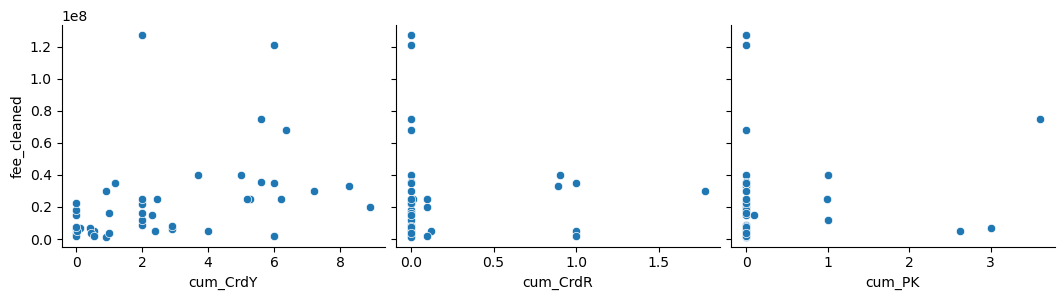

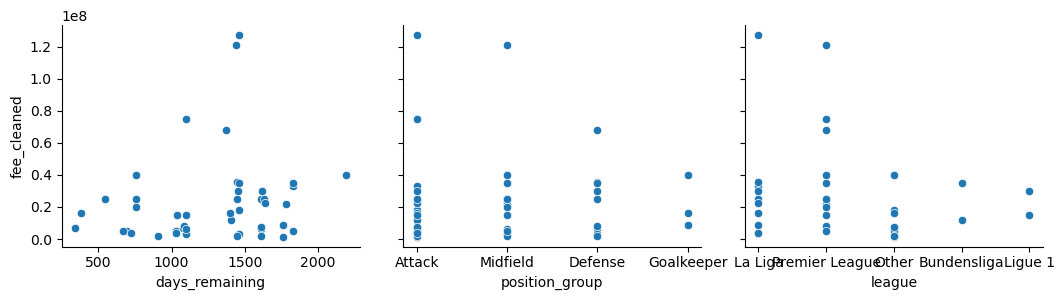

In [12]:
sns.pairplot(df, x_vars=['age', 'transfer_period', 'year', ],
             y_vars=['fee_cleaned'], height=3, aspect=1.2)
sns.pairplot(df, x_vars=['cum_Min', 'cum_Gls', 'cum_Ast'],
             y_vars=['fee_cleaned'], height=3, aspect=1.2)
sns.pairplot(df, x_vars=['cum_CrdY', 'cum_CrdR', 'cum_PK'],
             y_vars=['fee_cleaned'], height=3, aspect=1.2)
sns.pairplot(df, x_vars=['days_remaining', 'position_group', 'league'],
             y_vars=['fee_cleaned'], height=3, aspect=1.2)


In [13]:
df.drop(['cum_CrdY','cum_CrdR','cum_PK','transfer_period'],axis=1,inplace=True)

In [14]:
#Premier League is the only value that makes a substantial difference in value
for i,d in df.iterrows():
    if d['league'] != 'Premier League':
        df.loc[i, 'league'] = 'Other'

## Models

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

In [16]:
X = df.drop('fee_cleaned', axis=1)
y = df['fee_cleaned']

In [17]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
num_cols = ['age', 'year', 'cum_Min', 'cum_Gls', 'cum_Ast']

# Create a RobustScaler object
scaler = RobustScaler()

# fit and transform the numerical columns using the scaler
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [19]:
# Define a dictionary to map position groups to numerical values
pos_dict = {'Attack': 1, 'Midfield': 2, 'Defense': 3, 'Goalkeeper': 4}
league_dict = {'Other':1, 'Premier League':2}

# Replace position groups with numerical values in X_train
X_train['position_group'] = X_train['position_group'].map(pos_dict)
X_test['position_group'] = X_test['position_group'].map(pos_dict)
X_train['league'] = X_train['league'].map(league_dict)
X_test['league'] = X_test['league'].map(league_dict)

### Linear Regression

In [20]:
from sklearn import linear_model

In [21]:
np.random.seed(42)
# Create linear regression object
regr = linear_model.LinearRegression()

In [22]:
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [23]:
# Calculate the mean squared error of the predictions
mse_LR = mean_squared_error(y_test, y_pred)
print("Mean squared error = ", mse_LR)

Mean squared error =  333427393315724.4


In [24]:
r2_LR = r2_score(y_test, y_pred)
print("R-squared LR = ", r2_LR)

R-squared LR =  -1.7892236912800055


### Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [26]:
# Initialize the Random Forest Regression model
rf = RandomForestRegressor(max_depth= 5, max_features= 'sqrt', n_estimators= 200)

# Train the model on the training set
rf.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = rf.predict(X_test)

In [27]:
# Calculate the mean squared error of the predictions
mse_RF = mean_squared_error(y_test, y_pred)
print("Mean squared error = ", mse_RF)

Mean squared error =  122298172626628.92


In [28]:
r2_RF = r2_score(y_test, y_pred)
print("R-squared RF = ", r2_RF)

R-squared RF =  -0.023062193835524436


### KNeighboursRegressor

In [29]:
from sklearn.neighbors import KNeighborsRegressor

In [30]:
# Create a KNeighborsRegressor object
knn_reg = KNeighborsRegressor(algorithm = 'brute', n_neighbors = 7, weights = 'distance')

# Fit the model to the training data
knn_reg.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = knn_reg.predict(X_test)

# Calculate the mean squared error of the predictions
mse_KNN = mean_squared_error(y_test, y_pred)
print("Mean squared error = ", mse_KNN)

Mean squared error =  731670115689072.9


In [31]:
r2_KNN = r2_score(y_test, y_pred)
print("R-squared KNN= ", r2_KNN)

R-squared KNN=  -5.120647738589093


### Best Result

In [32]:
mse_list = [mse_KNN, mse_LR, mse_RF]
min_mse = min(mse_list)
min_mse_index = mse_list.index(min_mse)
min_mse_variable = None

if min_mse_index == 0:
    min_mse_variable = 'mse_KNN'
elif min_mse_index == 1:
    min_mse_variable = 'mse_LR'
else:
    min_mse_variable = 'mse_RF'

print('Best Algorithm is',min_mse_variable, 'with', min_mse)


Best Algorithm is mse_RF with 122298172626628.92


1. Best is RF
